<a href="https://colab.research.google.com/github/FabioBoccia/Progetto_ESM/blob/dev/generate_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.

In [ ]:
%cd /content
%rm -r sample_data
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers
!mkdir -p logs
!cp -r /content/drive/MyDrive/2021-04-23T18-19-01_ffhq_transformer logs/

Next, we install minimal required dependencies.

In [ ]:
!pip install --upgrade omegaconf einops transformers pytorch-lightning
#!pip list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip install -U

## Loading the model

We load and print the config.

In [1]:
import sys
%cd /content/taming-transformers
sys.path.append(".")
from omegaconf import OmegaConf
config_path = "/content/taming-transformers/logs/2021-04-23T18-19-01_ffhq_transformer/configs/2021-04-23T18-19-01-project.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

/content/taming-transformers
data:
  params:
    batch_size: 24
    num_workers: 24
    train:
      params:
        size: 256
      target: taming.data.faceshq.FFHQTrain
    validation:
      params:
        size: 256
      target: taming.data.faceshq.FFHQValidation
  target: cutlit.DataModuleFromConfig
model:
  base_learning_rate: 0.0625
  params:
    cond_stage_config: __is_unconditional__
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
          resolution: 256
          z_channels: 256
        embed_dim: 256
        lossconfig:
          target: taming.modules.losses.vqperceptual.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    first_stage_key: image
    transformer_config:
   

Instantiate the model and load the checkpoint.

In [2]:
from taming.models.cond_transformer import Net2NetTransformer
import torch
model = Net2NetTransformer(**config.model.params)
ckpt_path = "/content/taming-transformers/logs/2021-04-23T18-19-01_ffhq_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cuda")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


In [3]:
model.cuda().eval()
torch.set_grad_enabled(False)

## Sample an image

```
# Default values:
num_samples = 1
batch_size = 1
top_k = 150
top_p = 0.9
temperature = 1.0

logdir="/content/drive/MyDrive/"
```



In [6]:
num_samples = 1
batch_size = 1
top_k = 150
top_p = 0.9
temperature = 1.0

logdir="/content/drive/MyDrive/"

In [10]:
from scripts.sample_fast import sample_unconditional
from tqdm import tqdm
from PIL import Image
import numpy as np

def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

@torch.no_grad()
def run_live(model, batch_size, temperature, top_k, unconditional=True, num_samples=50000, top_p=None):
    print(f"Running in unconditional sampling mode, producing {num_samples} samples.")
    batches = [batch_size for _ in range(num_samples//batch_size)] + [num_samples % batch_size]
    for n, bs in tqdm(enumerate(batches), desc="Sampling"):
        if bs == 0: break
        logs = sample_unconditional(model, batch_size=bs, temperature=temperature, top_k=top_k, top_p=top_p)
        show_image(logs["samples"])

Logging to /content/drive/MyDrive/samples/top_k_150_temp_1.00_top_p_0.9/samples/top_k_150_temp_1.00_top_p_0.9
Running in unconditional sampling mode, producing 1 samples.


Sampling: 0it [00:00, ?it/s]

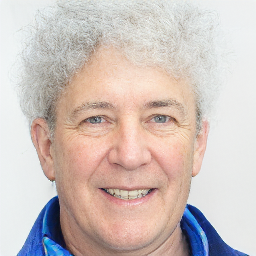

Sampling: 1it [00:08,  8.07s/it]


In [11]:
from scripts.sample_fast import run
import os 

logdir = os.path.join(logdir, "samples", f"top_k_{top_k}_temp_{temperature:.2f}_top_p_{top_p}")

print(f"Logging to {logdir}")
os.makedirs(logdir, exist_ok=True)

run_live(model, batch_size, temperature, top_k, unconditional=model.be_unconditional, num_samples=num_samples, top_p=top_p)
#run(logdir, model, batch_size, temperature, top_k, unconditional=model.be_unconditional, num_samples=num_samples, top_p=top_p)